In [617]:
import os
import re
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 300

In [618]:
# Read in data that was processed in OpenRefine
FILENAME = "raw-roast-reviews-openrefine.csv"
FILEPATH = os.path.join("data", FILENAME)
df_raw = pd.read_csv(FILEPATH)

In [619]:
def tweak_df(df):
    return (df
            .replace('na', np.nan)
            .dropna(subset=['origin_country_cluster', 'roaster_location', 'roast_level', 'body', 'aroma'])
            .assign(origin_country=lambda df_: (df_['origin_country_cluster']
                                                .str.split(',')
                                                .str[-1]
                                                .str.strip()
                                                ),
                    origin_region=lambda df_: (df_['origin_country_cluster']
                                               .str.split(',')
                                               .str[:-1]
                                               .str.join(',')
                                               .str.strip()
                                               ),
                    review_date = lambda df_: pd.to_datetime(df_['review_date'], format="%B %Y"),
                    acidity = lambda df_: df_['acidity'].fillna(df_['acidity/structure']),
                    agtron_external = lambda df_: (df_['agtron']
                                                   .str.split('/')
                                                   .str[0].str.strip()
                                                   .replace(['', 'NA', 'g', '0'], np.nan)
                                                   ),
                    agtron_ground = lambda df_: (df_['agtron']
                                                 .str.split('/')
                                                 .str[1].str.strip()
                                                 .replace(['', 'NA', 'wb', '0'], np.nan)),
            )
            .drop(columns=['acidity/structure', 'with_milk', 'bottom_line', 'agtron'])
            .dropna(subset=['acidity']) # drop rows where acidity is still NaN, these are espresso reviews
            .rename(columns={'country': 'roaster_country', 'roaster_location': 'roaster_city', 
                             'located in the administrative territorial entity': 'roaster_region',
                             'coordinate location': 'roaster_coordinates'})
            .assign(origin_region=lambda df_: df_['origin_region'].replace('', np.nan))
            .astype({'agtron_external': 'Int64', 'agtron_ground': 'Int64', 'acidity': 'float',
                     'aftertaste': 'Int64', 'aroma': 'float', 'body': 'float',
                     'rating': 'Int64', 'flavor': 'float',})
    )

df = tweak_df(df_raw)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5755 entries, 0 to 8672
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   roaster_city                 5755 non-null   object        
 1   roaster_country              5755 non-null   object        
 2   roaster_coordinates          5755 non-null   object        
 3   roaster_region               5750 non-null   object        
 4   roaster_location_identifier  5755 non-null   object        
 5   coffee_origin                5755 non-null   object        
 6   origin_country_cluster       5755 non-null   object        
 7   roast_level                  5755 non-null   object        
 8   est_price                    4626 non-null   object        
 9   review_date                  5755 non-null   datetime64[ns]
 10  aroma                        5755 non-null   float64       
 11  body                         5755 non-null   flo

In [620]:
grams_conversions = {
        'ounces': 28.3495,
        'pounds': 453.592,
        'grams': 1,
        'kilograms': 1000
}

currency_map = {
    'CNY': 'CNY',
    '$': 'USD',
    'NT$' : 'TWD',
    'GBP' : 'GBP',
    'HKD$' : 'HKD',
    'Nt$' : 'TWD',
    'RMB' : 'CNY',
    'AED$' : 'AED',
    'KRW$' : 'KRW',
    '£' : 'GBP',
    '$NT$': 'TWD',
    'CAD$' : 'CAD',
    '¥' : 'JPY',
    'pesos' : 'MXN',
    'USD$' : 'USD',
    'US$'  : 'USD',
    '$CAD' : 'CAD',
    'IDR$' : 'IDR',
    'AUD$' : 'AUD',
    '$NT' : 'TWD',
    'NTD$' : 'TWD',
    'NT' : 'TWD',
    'KRW' : 'KRW',
    'RMB$' : 'CNY',
    '$NTD' : 'TWD',
    'CNY$' : 'CNY',
    'THB$' : 'THB',
    'TWD$' : 'TWD',
    'HK$' : 'HKD',
    'E' : 'EUR',
    'GTQ' : 'GTQ',
    'Price:$': 'USD',
    'THB' : 'THB',
 }
# Cleaning up price and units 
quantity = (df['est_price']
 .str.split('[/;]', n=1, expand=True)
 .dropna()
 .rename(columns={0: 'price', 1: 'amount'})
 .loc[:, 'amount']
 .str.replace('oz.*', 'ounces')
 .str.replace('ouncues|onces|ounce$|-ounce|ounces.*$', 'ounces', regex=True)
 .str.replace(r'oz.', 'ounces', regex=False)
 .str.replace(r'g ', 'grams', regex=False)
 .str.replace(r'-gram', ' grams', regex=True)
 .str.replace(r'g. ', 'grams', regex=False)
 .str.replace(r' g.', ' grams', regex=False)
 .str.replace(r'g$', ' grams', regex=True)
 .str.replace(r'\((.*?)\)', '', regex=True)
 .str.replace(r';|\(|\$.*$', '', regex=True)
 .str.replace('tin', '', regex=False)
 .str.replace('  ', ' ', regex=True)
 .str.replace('8 18 grams pouches', '152 grams', regex=False)
 .str.replace('350 grams 12.3 ounces', '350 grams', regex=False)
 .str.strip()
 .mask(lambda x: x.str.contains('capsule|packet|pods|vue|k-cups|sticks|tubes|cups|boxed|discs|can', case=False), np.nan)
 )

quantity_unit= (quantity
                .str.split(' ', expand=True)
                .rename(columns={0: 'quantity', 1: 'unit'})
                # if quantity equals 'pound' set quantity to 1 and unit to pounds
                .assign(unit=lambda df_: df_['unit'].mask(df_['quantity'] == 'pound', 'pound'),
                        quantity = lambda df_: df_['quantity'].mask(df_['quantity'] == 'pound', 1)
                )
                .astype({'quantity': 'float'})
                # convert all units to grams
                .assign(quantity_grams = lambda df_: df_['quantity'] * df_['unit'].map(grams_conversions))
)

price = (df['est_price']
         .str.split('[/;]', n=1, expand=True)
         .loc[:, 0]
         .str.replace(',', '', regex=False)
         # regex to extract the price from the string
        .str.extract(r'(\d+\.\d+|\d+)')
        .loc[:, 0]
        .astype('float')
        .rename('nominal_price')
)

currency = (df['est_price']
         .str.split('[/;]', n=1, expand=True)
         .loc[:, 0]
         .str.replace(',', '', regex=False)
         # regex to extract the price from the string
        .str.replace(r'(\d+\.\d+|\d+)', '', regex=True)
        .str.strip()
        .str.replace(' ', '')
        .map(currency_map, na_action='ignore')
        .rename('currency')
)

df = df.join(quantity_unit, how='left').join(price, how='left').join(currency, how='left')


df.review_date.dt.date.astype('str').drop_duplicates().sort_values().to_csv('data/dates.csv', index=False)

with open('data/exchange_rates.json', 'r') as f:
    exchange_rates = json.load(f)
    
df = (df
      .dropna(subset=['review_date', 'currency'])
      .astype({'review_date': 'str'})
      .assign(exchange_rate = lambda df_: df_.apply(lambda x: exchange_rates[x['review_date']][x['currency']], axis=1))
      .assign(price_usd = lambda df_: df_['nominal_price'] / df_['exchange_rate'])
      .round({'price_usd': 2})
)

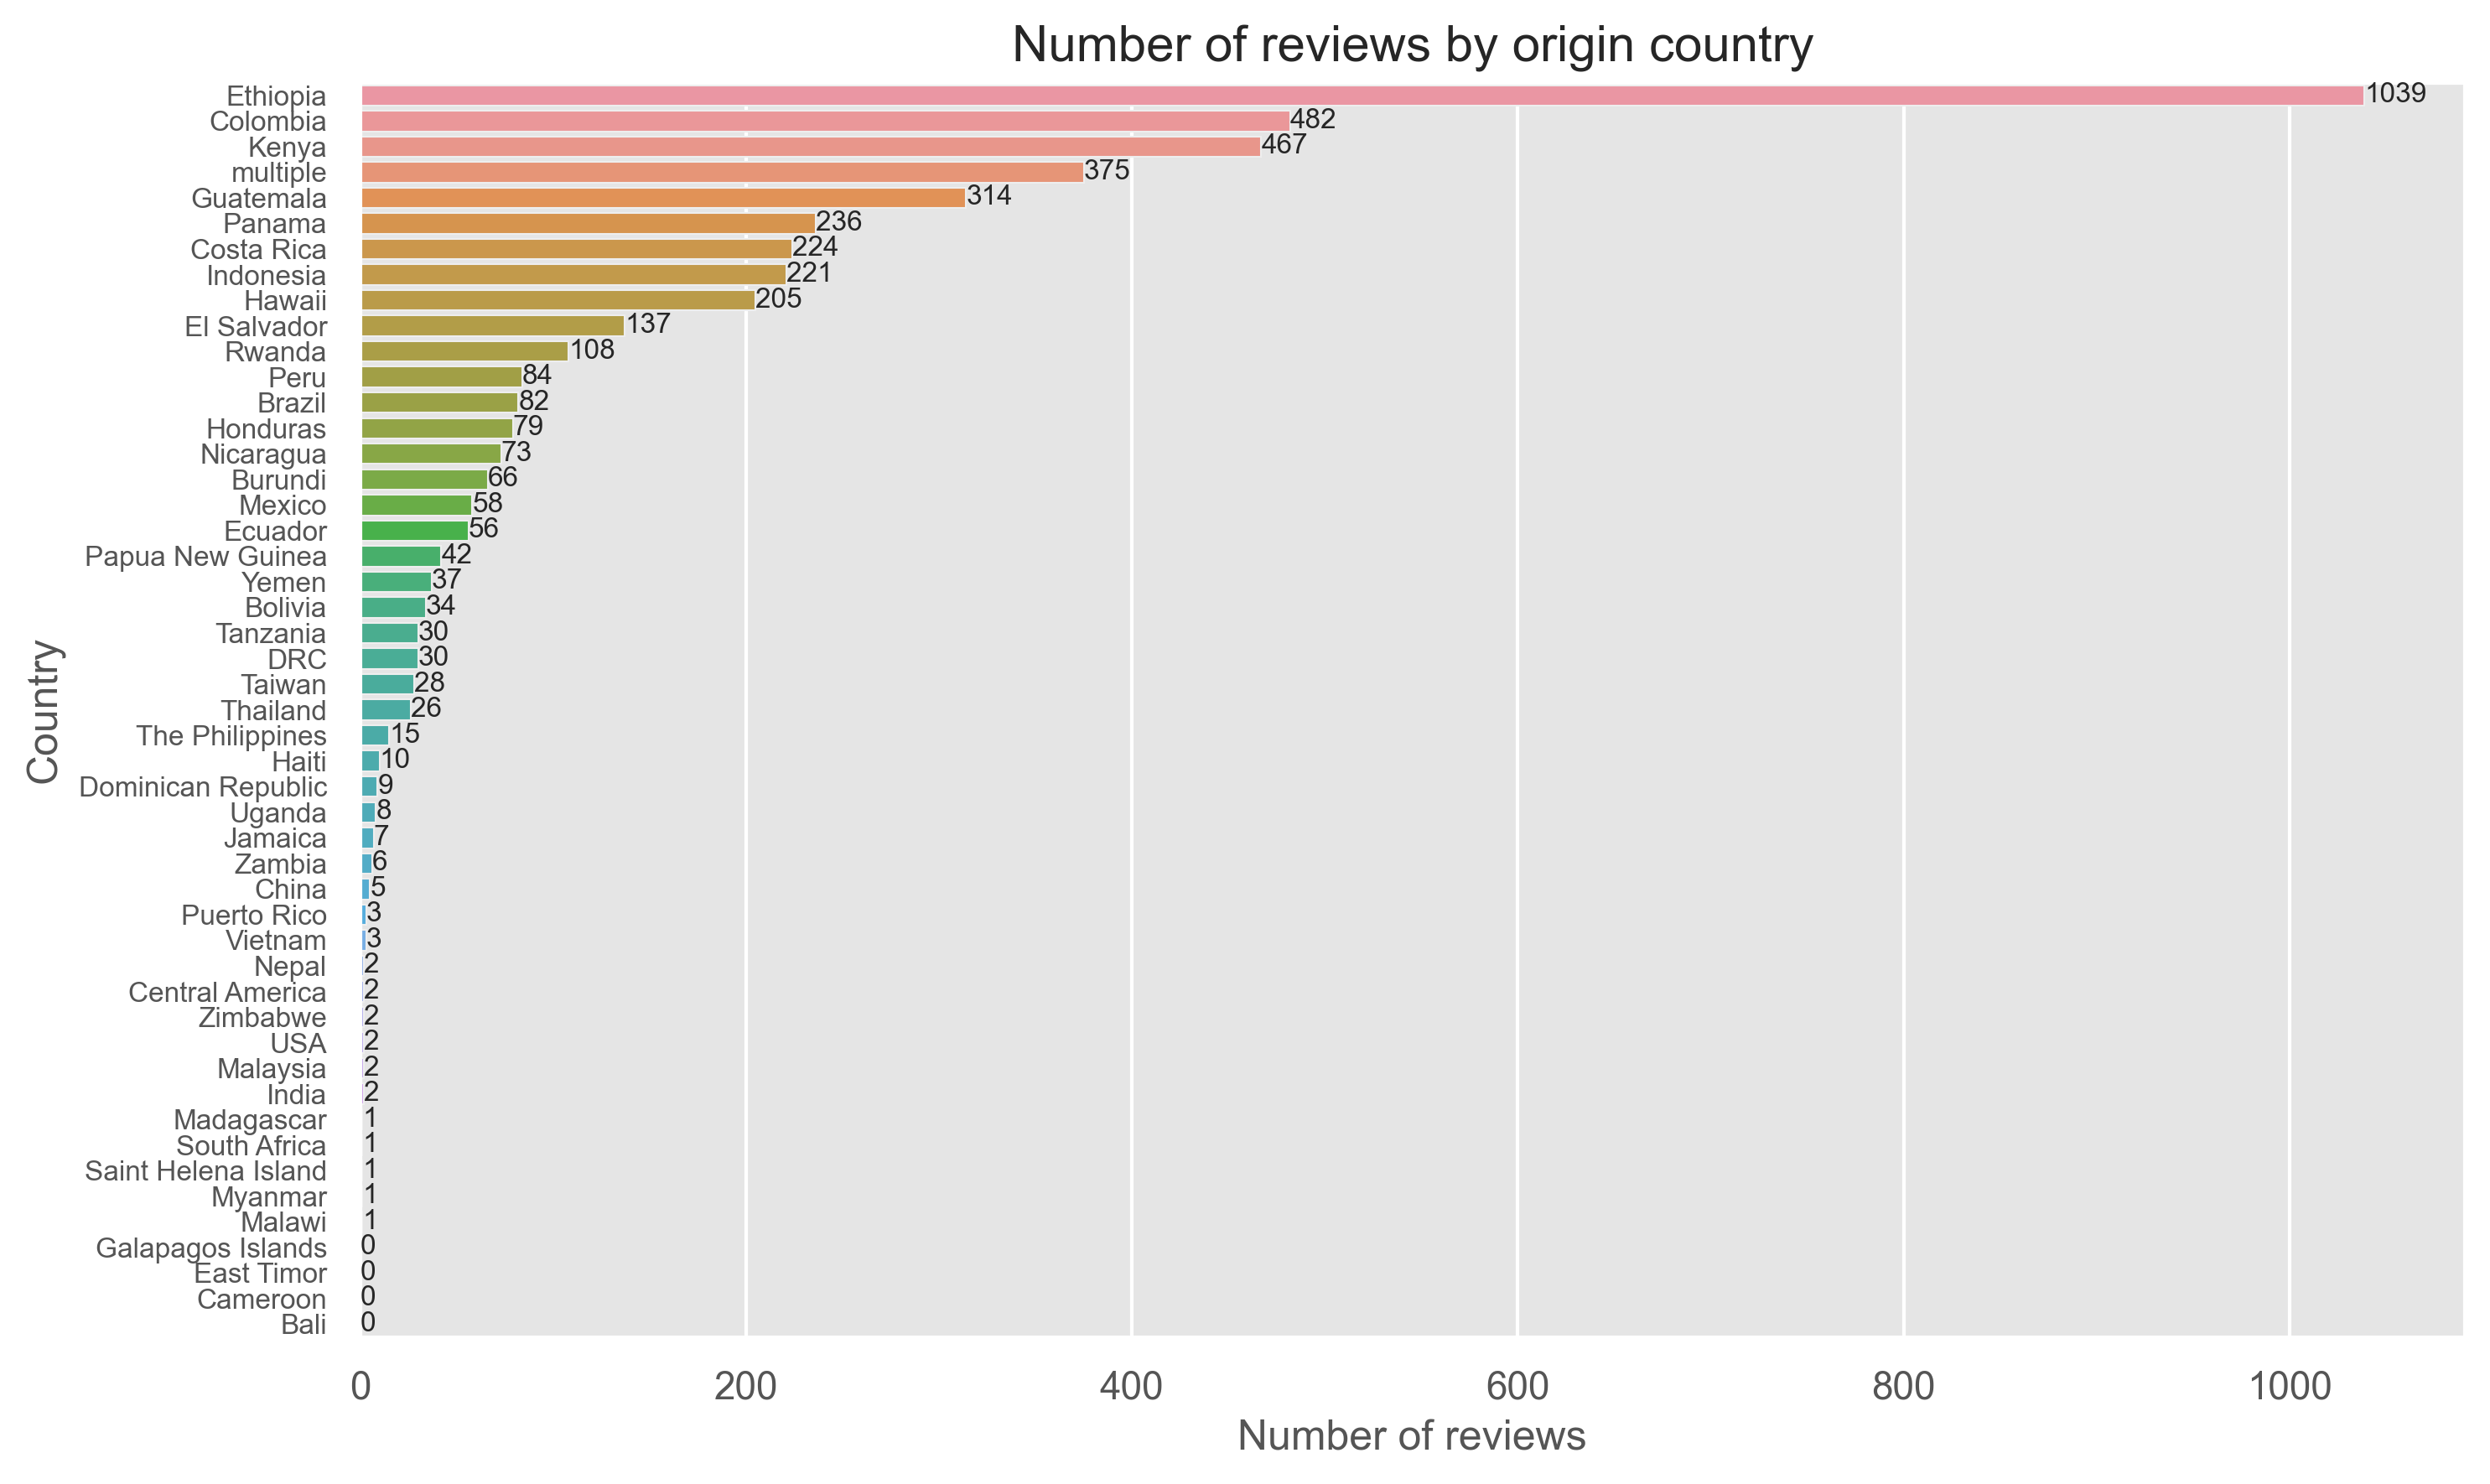

In [621]:
# plot number of reviews by country in seaborn
def plot_reviews_by_country(df):
    plt.figure(figsize=(10, 6))
    df = df.replace('Democratic Republic of the Congo', 'DRC')
    ax = sns.countplot(y='origin_country', data=df, order = df['origin_country'].value_counts().index)
    ax.bar_label(ax.containers[0], fontsize=8,)
    plt.yticks(fontsize=8)
    plt.title('Number of reviews by origin country')
    plt.xlabel('Number of reviews')
    plt.ylabel('Country')
    plt.tight_layout()
    plt.show()

plot_reviews_by_country(df)

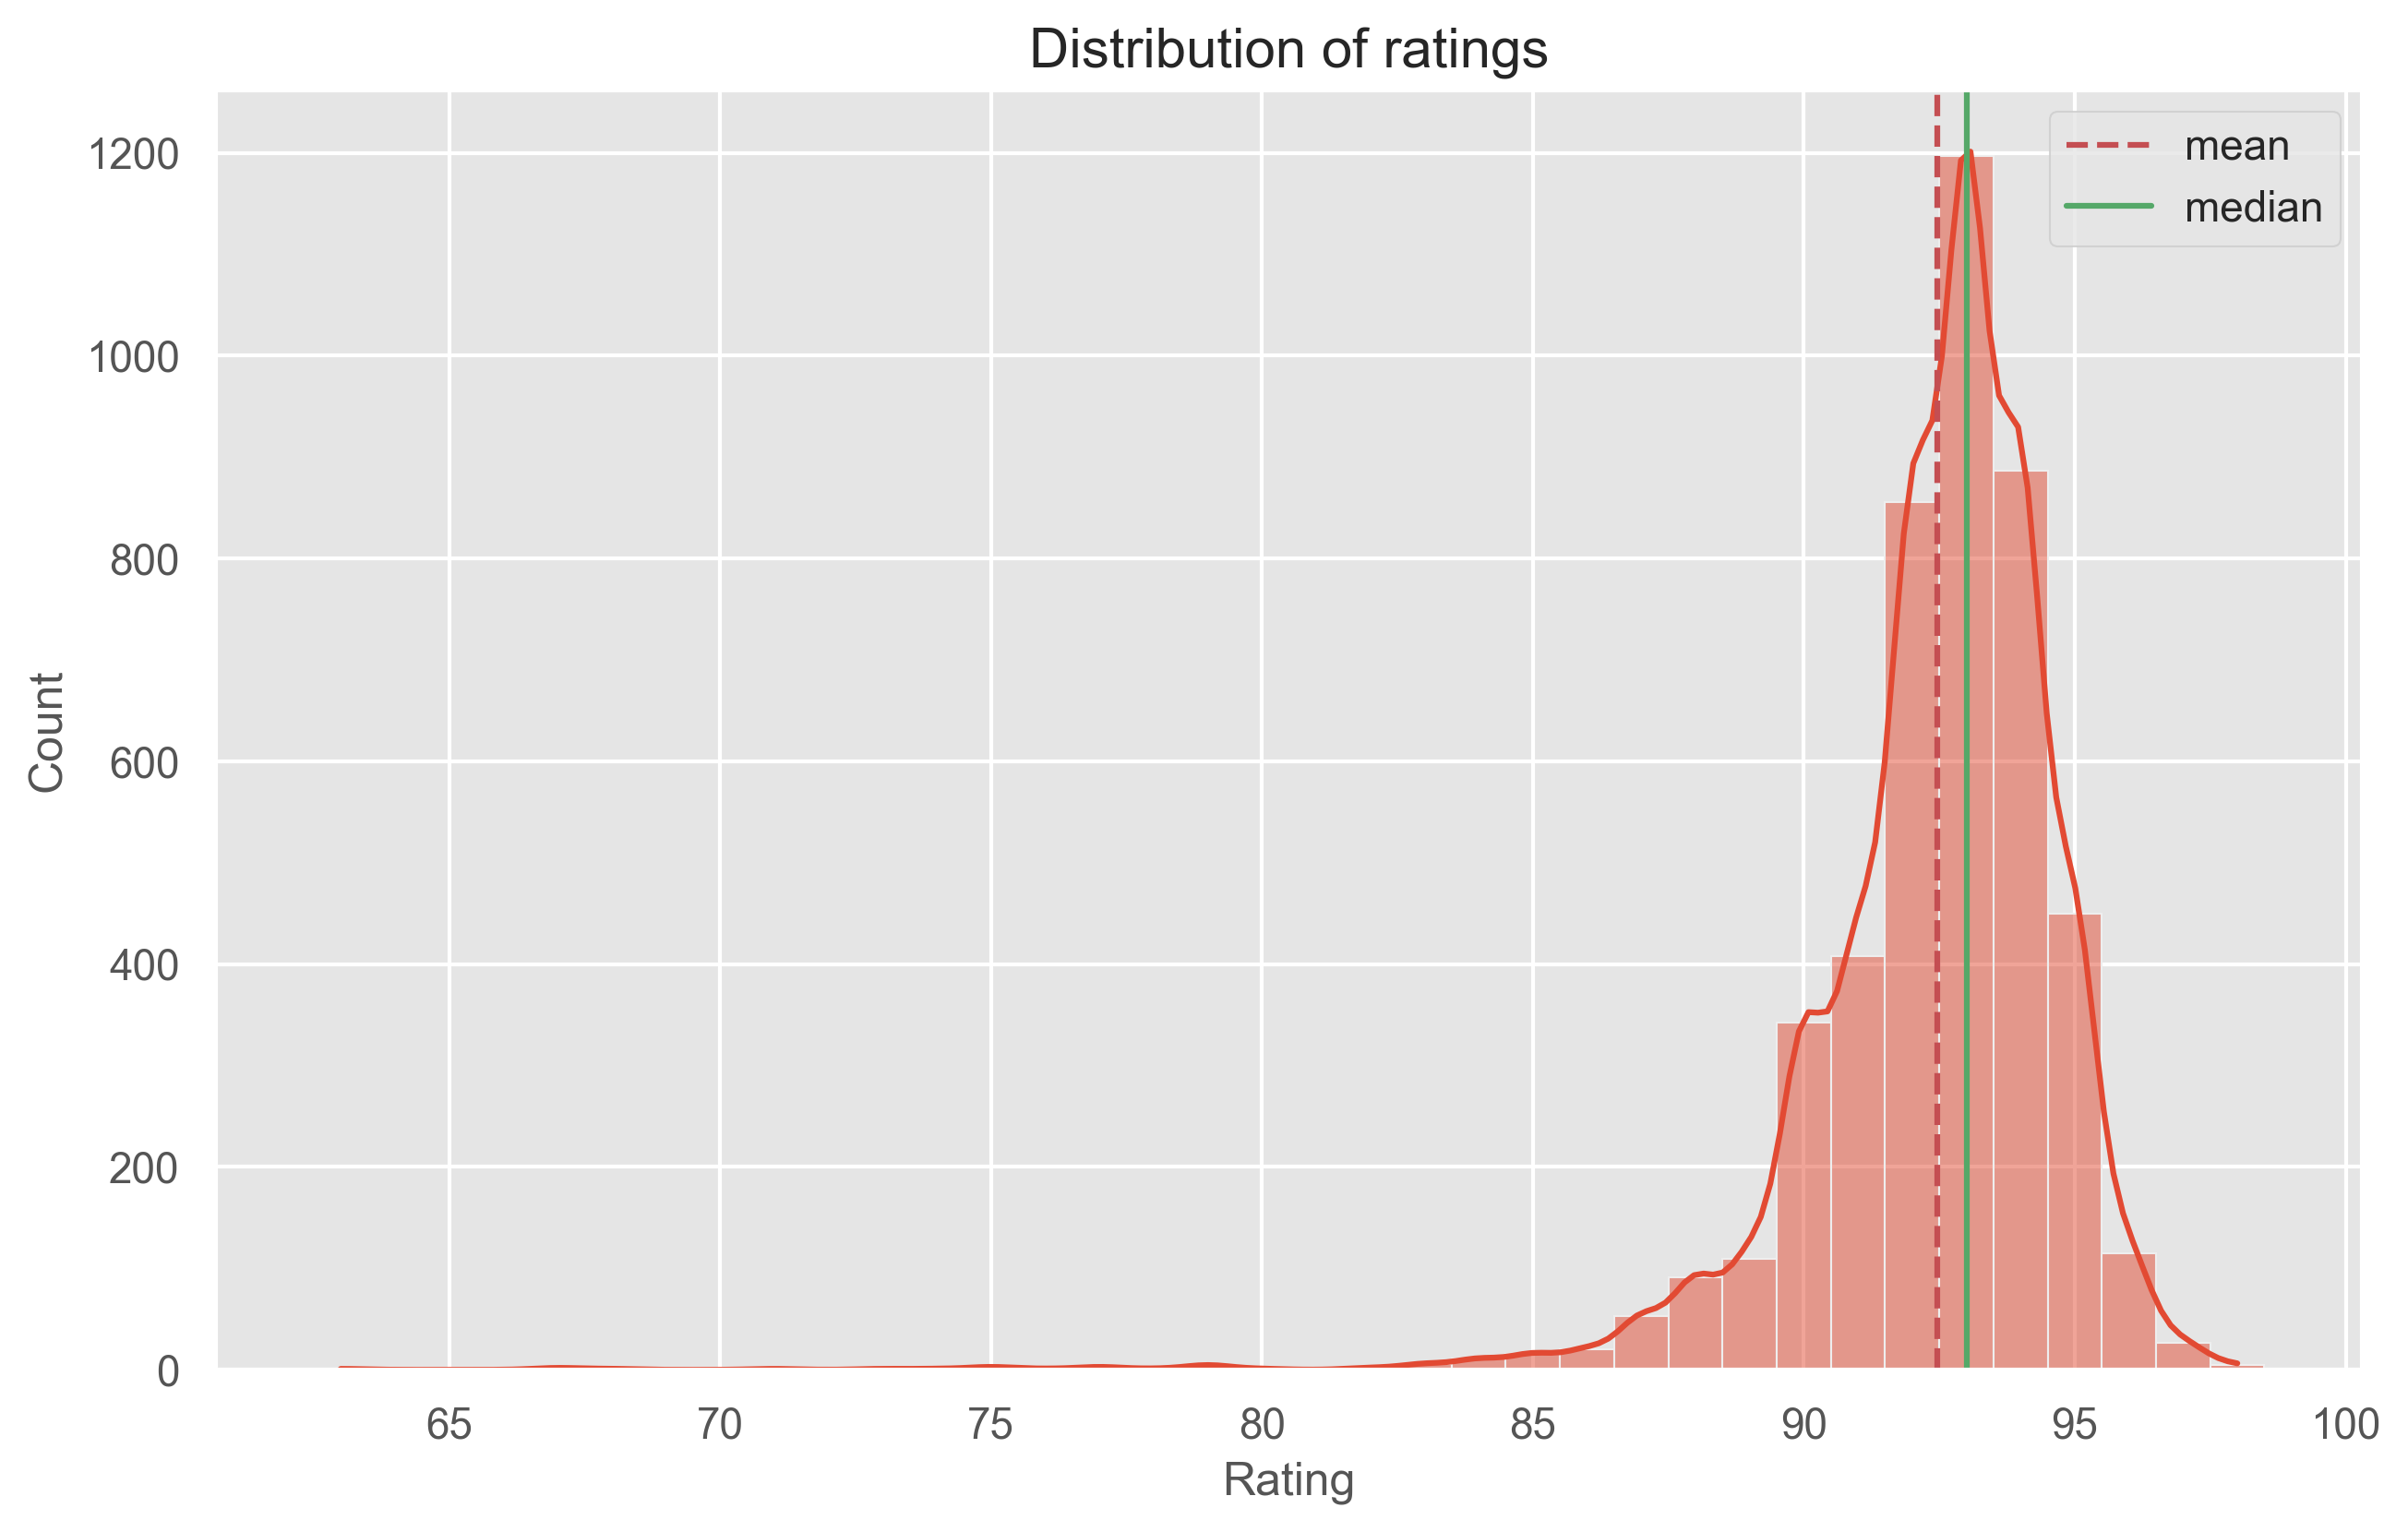

In [622]:
def plot_ratings_distribution(df):
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data=df.astype({'rating':'float'}), x='rating',kde=True, discrete=True)
    ax.set_title('Distribution of ratings')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    ax.axvline(df['rating'].mean(), color='r', linestyle='--', label='mean')
    ax.axvline(df['rating'].median(), color='g', linestyle='-', label='median')
    ax.legend()
    plt.show()
    
plot_ratings_distribution(df)